# XGBoost feature selection
(using stratified 5-fold cross validation)

### Plain English summary
Machine learning algorithms (such as XGBoost) were devised to deal with enormous and complex datasets, with the approach that the more data that you can throw at them, the better, and let the algorithms work it out themselves.

However this approach can make it tricky to be able to explain a coherent story about how the models are working, the relationships that they have found, and how they have made their predictions.

Our machine learning work has taken on an additional focus - to make our work as explainable as possible. Both in terms of being able to explain how the models have arrived at their outcome, and in the ease at which we can disseminate our work to a wider audience. For us to have explainable models we want to have a balance between model complexity and model accuracy in order to be able to explain our models, whilst maintaining model performance.

In this notebook we create a model to predict if a patient should receive thrombolysis using just a single input feature, chosen as the feature that gave the model it's best performance. The single feature that gave the best model performance was "Arrival-to-scan time". Fixing this feature in the model, we repeated the process to chose the next single feature to add to the model. The best single feature to include next was "Stroke type". We repeated this process, choosing the next feature to add to the model until 25 features were included (it was limited to 25 features for computational time purposes).

We found that a model with eight features is able to provide 99% of the accuracy obtained when all 84 features are used, and that these eight features are also independent of each other (refer to section Check correlation between selected features to confirm this).

When disseminating the initial 8 feature model outputs to clinicians we observed how, when they were discussing whether a particular patient was suitable to recieve thrombolysis, they would often discuss the patients age. Patient age was the 10th feature to be selected by this process. We decided to extend the feature selected list to include the 9th and 10th selected features: onset during sleep and patient age. This model provided >99% of the accuracy obtained when all 84 features are used. These ten features are also largely independent of each other (refer to section Check correlation between selected features to confirm this).

This is not saying that these are the 10 most important features, as another highly correlated feature may also have been important, but it is now not needed to be included in the model.

We will train future models using these ten features.

NOTE: This experiment was performed using data where time from onset to arrival, and tiem from arrival to scan, were rounded to the nearest 5 minutes. When more precise data is used feature order varies slightly after feature 8.

### Model and data
XGBoost models were trained on stratified k-fold cross-validation data. The full dataset contains 84 features that describe the patient (in terms of their clinical characteristics, the stroke pathway, and the stroke team that they attended). Features to be included in the model were sequentially selected as the single best feature to add to the model in terms of performance from the area under the receiver operating characteristic (ROC AUC) curve. When included, the hospital feature is included as a one-hot encoded feature.

### Aims
Select up to 25 features (from the full set of 84 features) using forward feature selection. Features are selected sequentially (using the greedy approach), choosing the feature that leads to most improvement in ROC AUC score.
Decide on the number of features to include in future models

### Observations
Ten features are able to provide a ROC AUC of 0.919 out of a maximum of 0.922. These features are also largely independent of each other.

Our best model with 1, 2, 10 & 84 features had a ROC AUC of 0.715, 0.792, 0.919 & 0.922.

## Import libraries

In [65]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import confusion_matrix

import seaborn as sns

from sklearn.metrics import roc_auc_score

## Set up paths and filenames

In [80]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

  #  data_path: str = '../'
  #  data_filename: str = 'SAMueL ssnap extract v2.csv'
    data_save_path: str = './'
  #  data_save_filename: str = 'reformatted_data.csv'
  #  database_filename: str = 'samuel.db'
  #  notebook: str = '01'
  #  kfold_folder: str = 'data/kfold_5fold/'

    data_read_path: str = '../data/kfold_5fold'
#    data_read_filename: str = '03_reformatted_data_ml.csv'
 #   data_save_path: str = './kfold_5fold'
#    data_save_filename: str = 'train.csv'
    notebook: str = '02_'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [67]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(paths.data_read_path + '/03_train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(paths.data_read_path + '/03_test_{0}.csv'.format(i)))

temp_set = set(train_data[0].columns)

if 'weekday' in temp_set:
    print ("weekday")
if 'discharge_destination' in temp_set:
    print ("distination")

for feature, prefix in zip(features_to_one_hot, list_prefix):
    train_data[0] = convert_feature_to_one_hot(train_data[0], feature, prefix)

temp_set = set(train_data[0].columns)
if 'weekday' in temp_set:
    print ("weekday")
if 'discharge_destination' in temp_set:
    print ("dich")

df_feature = pd.get_dummies(
    df[feature_name], prefix = prefix)
df = pd.concat([df, df_feature], axis=1)
df.drop(feature_name, axis=1, inplace=True)

Get list of features

In [68]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 51 features


## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [69]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [70]:
features_to_one_hot = ["stroke_team", "weekday"]#, "discharge_destination"]
list_prefix = ["team", "weekday"]#, "disch_dest"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

for feature, prefix in zip(features_to_one_hot, list_prefix):
    for k_fold in range(5):
        train_data[k_fold] = convert_feature_to_one_hot(train_data[k_fold], feature, prefix)
        test_data[k_fold] = convert_feature_to_one_hot(test_data[k_fold], feature, prefix)

Each train and test set not necessarily have all columns.
Check if each train and test dataset contains each category. If not, include as a new column with all 0 values (need same columns in all datasets)

set_one_hot_features = set()
for k_fold in range(5):
    temp_set = set(train_data[k_fold].columns).union(set(test_data[k_fold].columns))
    set_one_hot_features = set_one_hot_features.union(temp_set)

Print if any columns are missing.

for k_fold in range(5):
    if len(list(set_one_hot_features - set(train_data[k_fold].columns))) > 0:
        print(f"Train kfold {k_fold}: {set_one_hot_features - set(train_data[k_fold].columns)}")
    if len(list(set_one_hot_features - set(test_data[k_fold].columns))) > 0:
        print(f"Test kfold {k_fold}: {set_one_hot_features - set(test_data[k_fold].columns)}")

Just one hot encoded levels, so add missing columns to each dataframe, with all instances taking value 0

for k_fold in range(5):
    features_to_add = set_one_hot_features - set(train_data[k_fold].columns)
    for f in features_to_add:
        train_data[f] = 0

    features_to_add = set_one_hot_features - set(test_data[k_fold].columns)
    for f in features_to_add:
        test_data[f] = 0

## Fit XGBoost model

Train model with all features (as comparison)

In [71]:
r_square_kfold = []
roc_auc_ovr_kfold = []

# Loop through k folds
for k_fold in range(5):

    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # Get X and y
    X_train = train.drop('discharge_disability', axis=1)
    X_test = test.drop('discharge_disability', axis=1)
    y_train = train['discharge_disability']
    y_test = test['discharge_disability']

    # One hot encode categorical features
    for feature, prefix in zip(features_to_one_hot, list_prefix):
        X_train = convert_feature_to_one_hot(X_train, feature, prefix)
        X_test = convert_feature_to_one_hot(X_test, feature, prefix)

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)

    # Get target categories from model
    classes = model.classes_

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

# Get average result from all k-fold splits
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)

print (f'All features, AUC: {roc_auc_ovr_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(roc_auc_ovr_mean):0.3f})')

All features, AUC: 0.813 (std across 5 kfolds: 0.000)


Check that the five ROC AUC are not identical (to give the stddev 0)

In [72]:
roc_auc_ovr_kfold

[0.813486711089495,
 0.8100698007345907,
 0.8131159846953937,
 0.815235269138486,
 0.8137205616482808]

## Fit XGBoost model

Loop through each feature in turn and train an XGBoost model with that feature added to the dataset (for each k-fold split). Choose the single best feature to add to the model in terms of performance from the ROC AUC using one vs rest (mean of the k-fold splits).

Repeat until 25 features have been selected.

In [75]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(train_data[0].drop('discharge_disability', axis=1))
number_of_features = len(available_features)

# Loop through number of features
for i in range (25):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_roc_auc_ovr_kfold = []
        
        # Loop through k folds
        for k_fold in range(5):

            # Get k fold split
            train = train_data[k_fold]
            test = test_data[k_fold]

            # Get X and y
            X_train = train.drop('discharge_disability', axis=1)
            X_test = test.drop('discharge_disability', axis=1)
            y_train = train['discharge_disability']
            y_test = test['discharge_disability']
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]

            # One hot encode categorical features
            for cat_feature, prefix in zip(features_to_one_hot, list_prefix):
                if cat_feature in features_to_use:
                    X_train = convert_feature_to_one_hot(X_train, cat_feature, prefix)
                    X_test = convert_feature_to_one_hot(X_test, cat_feature, prefix)

            # Define model
            model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

            # Fit model
            model.fit(X_train, y_train)

            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)
            
            # Calculate ROC AUC for multiclass models, using One vs Rest
            feature_roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
            feature_roc_auc_ovr_kfold.append(feature_roc_auc_ovr)

        
        # Get average result from all k-fold splits
        feature_auc_mean = np.mean(feature_roc_auc_ovr_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_roc_auc_ovr_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: prior_disability, AUC: 0.691
Feature  2: stroke_severity, AUC: 0.772
Feature  3: stroke_team, AUC: 0.801
Feature  4: age, AUC: 0.805
Feature  5: year, AUC: 0.809
Feature  6: nihss_arrival_loc, AUC: 0.811
Feature  7: scan_to_thrombolysis_time, AUC: 0.813
Feature  8: thrombolysis_no_but_improving, AUC: 0.814
Feature  9: nihss_arrival_motor_arm_left, AUC: 0.815
Feature 10: nihss_arrival_best_gaze, AUC: 0.815
Feature 11: nihss_arrival_motor_arm_right, AUC: 0.816
Feature 12: male, AUC: 0.816
Feature 13: month, AUC: 0.816
Feature 14: nihss_arrival_dysarthria, AUC: 0.816
Feature 15: infarction, AUC: 0.816
Feature 16: arrive_by_ambulance, AUC: 0.816
Feature 17: thrombolysis_no_but_too_mild_severe, AUC: 0.816
Feature 18: diabetes, AUC: 0.817
Feature 19: thrombolysis_no_but_haemorrhagic, AUC: 0.817
Feature 20: nihss_arrival_motor_leg_right, AUC: 0.817
Feature 21: nihss_arrival_sensory, AUC: 0.817
Feature 22: afib_antiplatelet, AUC: 0.817
Feature 23: thrombolysis_no_but_other_medical,

Create a dataframe that contains the chosen features, and their mean ROC AUC across the k-fold splits, and the standard deviation.

In [76]:
results = pd.DataFrame()
results['number_features'] = range(1, len(chosen_features)+1)
results['feature'] = chosen_features
results['AUC'] = roc_auc_by_feature_number
results['AUC_Std'] = [np.std(auc) for auc in roc_auc_by_feature_number_kfold]
results

,number_features,feature,AUC,AUC_Std
0,1,prior_disability,0.690868,NaN
1,2,stroke_severity,0.771864,NaN
2,3,stroke_team,0.801343,NaN
3,4,age,0.805202,NaN
4,5,year,0.808704,NaN
5,6,nihss_arrival_loc,0.811169,NaN
6,7,scan_to_thrombolysis_time,0.812777,NaN
7,8,thrombolysis_no_but_improving,0.813740,NaN
8,9,nihss_arrival_motor_arm_left,0.814987,NaN
9,10,nihss_arrival_best_gaze,0.815241,NaN


In [81]:
results.to_csv(f'{paths.data_save_path}/{paths.notebook}feature_selection.csv', index=False)

## Plot the results
Plot a line graph showing the change in mean ROC AUC (across k-fold splits) for the number of features chosen in the model.

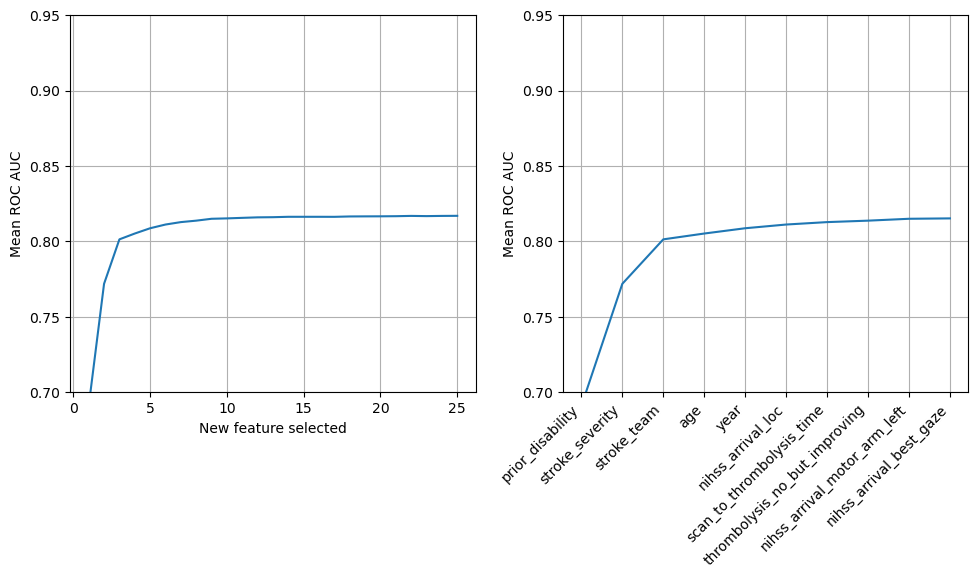

In [82]:
features_to_show = 10

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1.plot(results['number_features'], results['AUC'])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean ROC AUC')
ax1.set_ylim(0.7, 0.95)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results['feature'][:features_to_show],
         results['AUC'][:features_to_show])
xlabels = list(results['feature'])
xlabels = xlabels[:features_to_show]
ax2.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set_ylabel('Mean ROC AUC')
ax1.set_xlabel('New feature selected')
ax2.set_ylim(0.7, 0.95)
ax2.grid()

plt.tight_layout(pad=1.5)

plt.savefig(f'{paths.data_save_path}/{paths.notebook}feature_selection.jpg', dpi=300)
plt.show()

Save dictionary as a json (to be read in and used by the other notebooks).

In [84]:
feature_name_dict = {
    "prior_disability": "Prior disability level",
    "stroke_severity": "Stroke severity",
    "stroke_team": "Stroke team",
    "age": "Age",
    "year": "Year",
    "nihss_arrival_loc": "NIHSS arrival loc",
    "scan_to_thrombolysis_time": "Scan-to-thrombolysis time",
    "thrombolysis_no_but_improving": "Thrombolysis-No but improving",
    "nihss_arrival_motor_arm_left": "NIHSS arrival motor arm left",
    "nihss_arrival_best_gaze": "NIHSS arrival best gaze",
    "nihss_arrival_motor_arm_right": "NIHSS arrival motor arm right",
    "male": "Male",
    "month": "Month",
    "nihss_arrival_dysarthria": "NIHSS arrival dysarthria",
    "infarction": "Infarction",
    "arrive_by_ambulance": "Arrive by ambulance",
    "thrombolysis_no_but_too_mild_severe": "Thrombolysis-No but too mild severe",
    "diabetes": "Diabetes",
    "thrombolysis_no_but_haemorrhagic": "Thrombolysis-No but haemorrhagic",
    "nihss_arrival_motor_leg_right": "NIHSS arrival motor leg right",
    "nihss_arrival_sensory": "NIHSS arrival sensory",
    "afib_antiplatelet": "AFIB antiplatelet",
    "thrombolysis_no_but_other_medical": "Thrombolysis-No but other medical",
    "nihss_arrival_best_language": "NIHSS arrival best language",
    "congestive_heart_failure": "Congestive heart failure"
}

In [85]:
with open(f'{paths.data_save_path}/{paths.notebook}feature_name_dict.json', "w+") as f:
    json.dump(feature_name_dict, f)